In [1]:
from data.dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

from models.bi_lstm import Generator, Discriminator
from tools.viz import plot_anomalies, plot_data_values, plot_to_tensorboard

from typing import Tuple

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('./data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "multi"
        self.scaler = MinMaxScaler((-1, 1))
        
        # Train params
        self.lr = 0.0002
        self.epochs = 500
        
        self.model_out = Path('./runs/gru/')
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
        (self.model_out / "img").mkdir(exist_ok=True)
        
opts = Options()

# Setup Dataset

In [2]:
dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, remove_extreme=True, scaler=opts.scaler)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=opts.shuffle, 
                        num_workers=opts.nworkers, drop_last=opts.drop_last)

Removed 705 extreme values
Inputs shape: (11066, 3, 640)
Inputs head:
 [[[-1.          0.96053081  0.96056031 ...  0.78614874  0.78614874
    0.78614874]
  [-0.4834911  -0.48303799 -0.48258295 ...  0.99983155  0.99984836
    0.99986353]
  [ 0.1999884   0.20079141  0.20160554 ... -1.         -1.
   -1.        ]]

 [[-1.          0.97331674  0.97338166 ...  0.85886983  0.85886983
    0.85886983]
  [-0.47284225 -0.4723928  -0.47194147 ...  0.99986533  0.99987877
    0.99989089]
  [ 0.2347334   0.23580007  0.23688186 ... -1.         -1.
   -1.        ]]

 [[-1.          0.98365185  0.9837307  ...  0.84649725  0.84649725
    0.84649725]
  [-0.44609133 -0.44563623 -0.44517925 ...  0.99987057  0.99988349
    0.99989514]
  [ 0.26966237  0.27096428  0.27228496 ... -1.         -1.
   -1.        ]]

 [[-1.          0.94539212  0.94547067 ...  0.83151293  0.83151293
    0.83151293]
  [-0.49076893 -0.49033704 -0.4899033  ...  0.99988016  0.99989212
    0.99990291]
  [ 0.16532924  0.16629741  0.1672

In [3]:
# dataset.plot(title="Magnetic Field")

# Models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[2],
    hidden_size=64,
    output_size=dataset.inputs.shape[2],
    device=device,
    num_layers=2,
    dropout=0.1,
    bidirectional=False
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[2],
    hidden_size=64,
    device=device,
    num_layers=2,
    dropout=0.1,
    bidirectional=False
).to(device)

Using device:  cuda:0


In [5]:
exp_num = 3
logger = SummaryWriter(f"logs/gru_multi/e{exp_num}_D{netD.hidden_size}-L{netD.num_layers}_G{netG.hidden_size}-L{netG.num_layers}")
logger.add_graph(netG, torch.randn(opts.batch_size, 3, dataset.inputs.shape[2]).to(device))
logger.add_graph(netD, torch.randn(opts.batch_size, 3, dataset.inputs.shape[2]).to(device))
logger.add_text("Generator", netG.__str__())
logger.add_text("Discriminator", netD.__str__())

2023-03-06 22:29:55.950247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
print(netG,netD)

Generator(
  (lf0): Linear(in_features=640, out_features=320, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (main): GRU(320, 64, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=640, bias=True)
    (1): Tanh()
  )
) Discriminator(
  (lf0): Linear(in_features=640, out_features=320, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (main): GRU(320, 64, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


# Training

In [7]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.lr)

seq_len = 3


In [8]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    # For each batch in the dataloader
    for i, (x, _filename) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real = x.to(device)
        b_size = real.size(0)
        label = torch.full((b_size, seq_len, 1), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output, _ = netD(real)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn_like(real, device=device)
        # Generate fake batch with G
        fake, _ = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output, _ = netD(fake.detach())
        # Calculate D's loss on the all-fake batch        # Calculate D's loss on the all-fake batch

        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output, _ = netD(fake)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, opts.epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2),
                  end='\r', flush=True)

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        logger.add_scalars('Loss/train', {'G': errG.item(), 'D': errD.item()}, iters)

        iters += 1
        D_epoch_loss += errD.item()/b_size
        G_epoch_loss += errG.item()/b_size
    
    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    # TODO atirar para uma função
    if abs(D_epoch_loss-G_epoch_loss) < best_loss_dist and iters > 1000: 
        best_loss_dist = abs(D_epoch_loss-G_epoch_loss)
        torch.save(netG.state_dict(), opts.model_out / 'G.pth')
        torch.save(netD.state_dict(), opts.model_out / 'D.pth')
        
        if opts.train_plots:
            fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_data_values(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scales={"alpha [deg]":"linear"})
            plot_to_tensorboard(logger, fig, epoch, "train/best")
            plt.close(fig)
    elif epoch % 25 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_data_values(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scales={"alpha [deg]":"linear"})
            # plt.savefig(opts.model_out / f'img/inter_{epoch}.png')
            plot_to_tensorboard(logger, fig, epoch, "train/inter")
            plt.close(fig)
    

Starting Training Loop...


In [9]:
logger.flush()

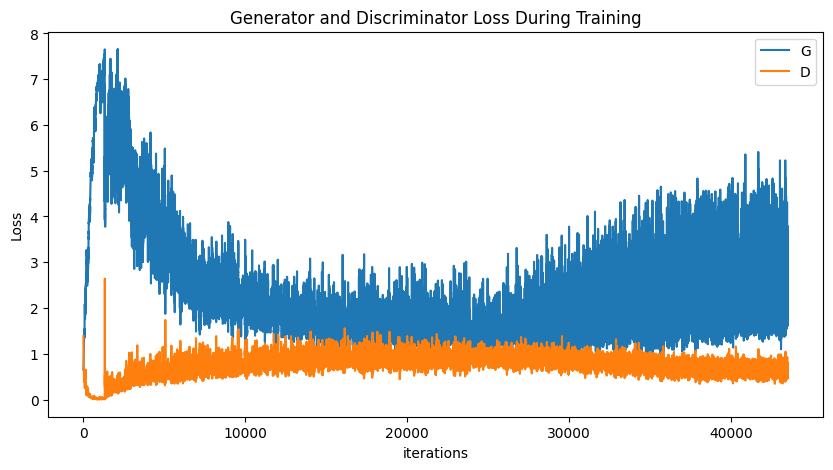

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Random Generated Inputs

In [11]:
# # load best model
# netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))

In [12]:
# lines = []

# # generate random samples
# for i in range(100):
#     noise = torch.randn_like(real, device=device)
#     fake, _ = netG(noise)
#     fake = fake.flatten(end_dim=1).detach().cpu().numpy()
#     lines.append(fake)


# inv_fake_data = dataset.unscale(np.array(lines))
# # inv_fake_data = pd.DataFrame(inv_fake_data)

In [13]:
# plot_data_values(inv_fake_data, "Random Generated", label="B [G]", scale="log")

# Anomaly Detection

In [36]:
# load best models
netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))
netD.load_state_dict(torch.load(opts.model_out / 'D.pth'))

netG.train = False
netD.train = False


class AnomalyParams:
    batch_size = 128
    
    # discriminator classification
    D_class_thresh = 0.5

    # reconstruction based
    mse_score_thresh = 1200
    feature_score_thresh = 1100
    niter = 80 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
    
opts_eval = AnomalyParams()
eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Inputs shape: (11771, 3, 640)
Inputs head:
 [[[-1.          0.96053081  0.96056031 ...  0.78614874  0.78614874
    0.78614874]
  [-0.84197182 -0.84459175 -0.84721484 ...  0.99982868  0.99984577
    0.9998612 ]
  [ 0.1999884   0.20079141  0.20160554 ... -1.         -1.
   -1.        ]]

 [[-1.          0.97331674  0.97338166 ...  0.85886983  0.85886983
    0.85886983]
  [-0.83877989 -0.84145651 -0.84413624 ...  0.99986245  0.99987618
    0.99988857]
  [ 0.2347334   0.23580007  0.23688186 ... -1.         -1.
   -1.        ]]

 [[-1.          0.98365185  0.9837307  ...  0.84649725  0.84649725
    0.84649725]
  [-0.83076146 -0.83357611 -0.83639389 ...  0.9998677   0.9998809
    0.99989282]
  [ 0.26966237  0.27096428  0.27228496 ... -1.         -1.
   -1.        ]]

 [[-1.          0.94539212  0.94547067 ...  0.83151293  0.83151293
    0.83151293]
  [-0.84415331 -0.84674147 -0.84933263 ...  0.99987729  0.99988954
    0.99990059]
  [ 0.16532924  0.16629741  0.16727945 ... -1.         -1.
   

## Discriminator Classification

In [16]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs, _ = netD(x.to(device))
    
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        class_avg = sample[1:].mean()
        scores.append((filename, 1-class_avg.item()))

Found 10334 anomalies


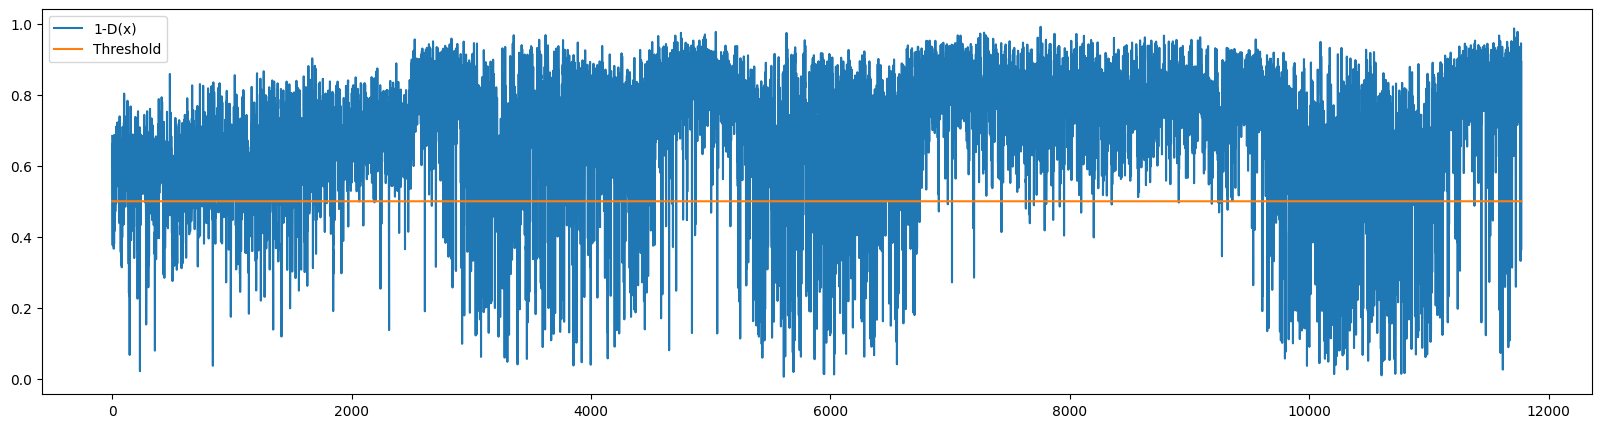

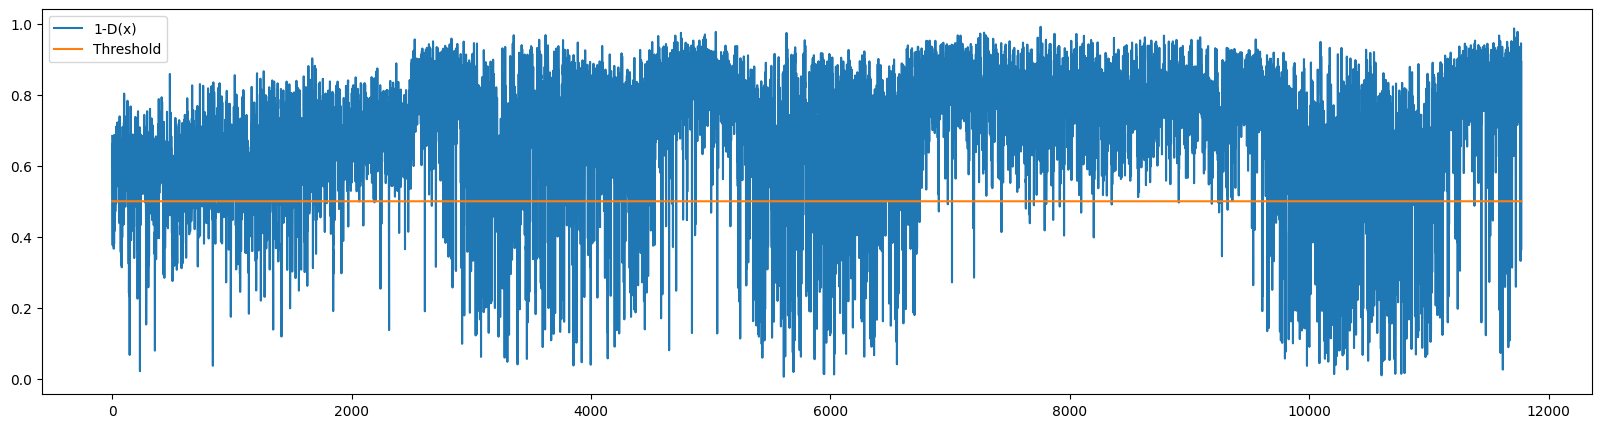

In [17]:
anomalies = [score[0] for score in scores if score[1] > opts_eval.D_class_thresh]
print(f"Found {len(anomalies)} anomalies")

scores_fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([score[1] for score in scores], label='1-D(x)')
ax.plot(opts_eval.D_class_thresh*np.ones(len(scores)), label='Threshold')
plt.legend()
_ = plot_to_tensorboard(logger, scores_fig, 0, "test/discr")

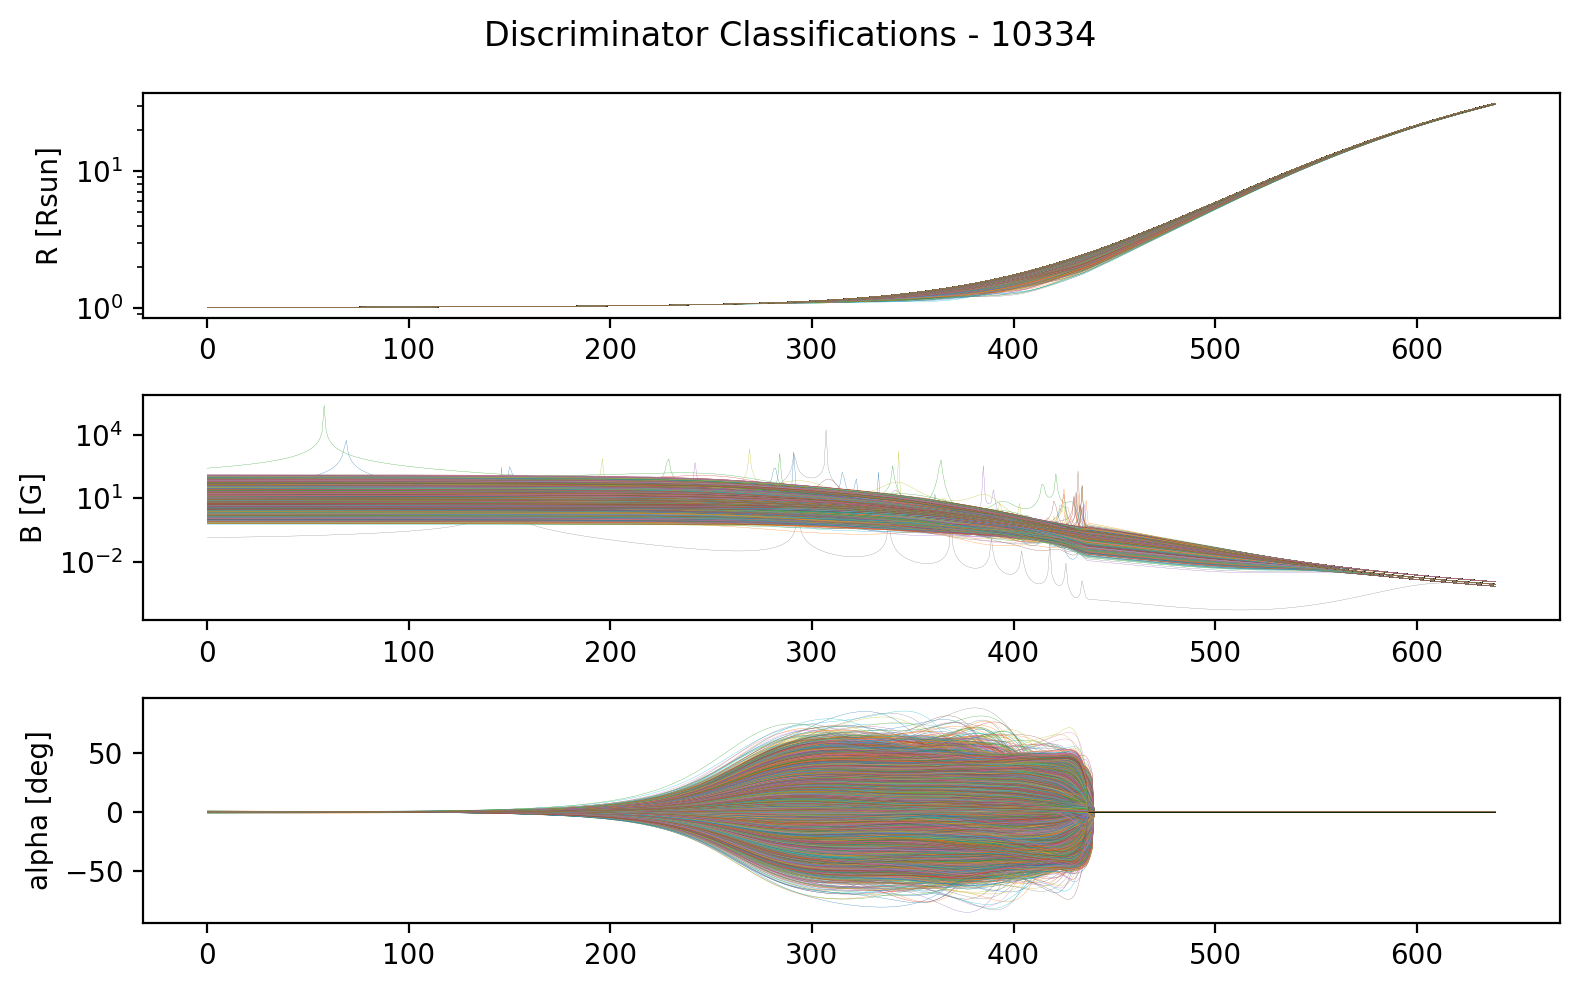

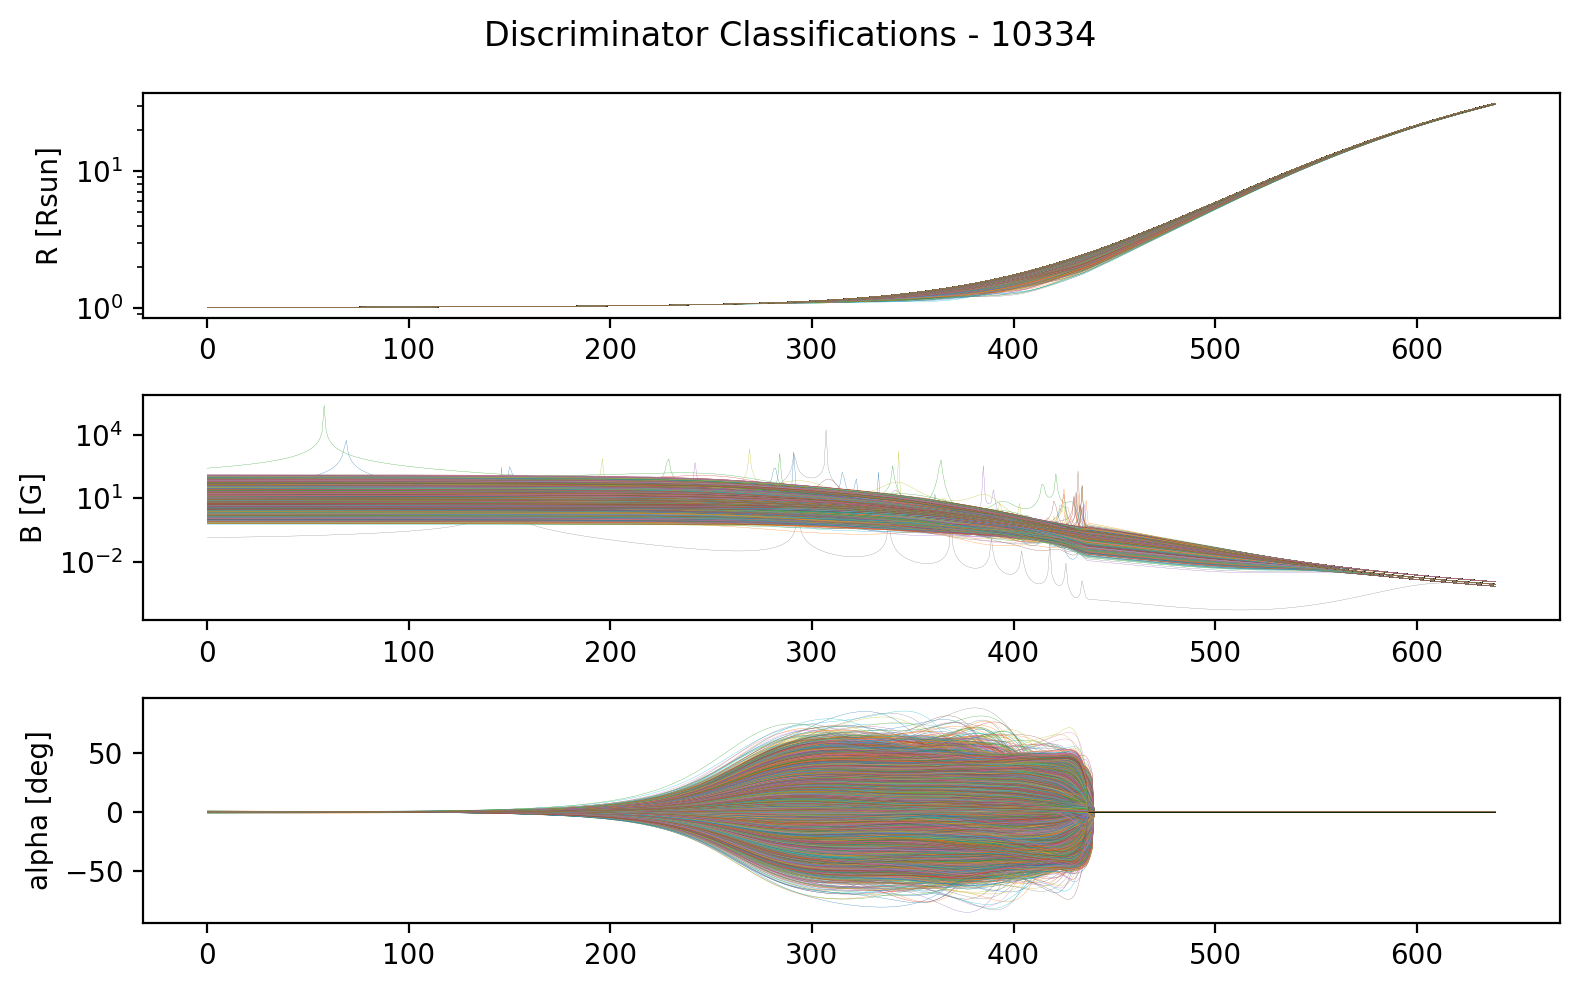

In [18]:
anomal_fig = plot_anomalies(anomalies, opts.data_path, f"Discriminator Classifications - {len(anomalies)}", figsize=(8, 5), dpi=200)
_ = plot_to_tensorboard(logger, anomal_fig, 0, "test/discr_anomalies")

## Reconstruction Based

In [19]:
def feature_anomaly_score(x, G_z, lambda_thresh=0.1):
    # residual loss between x and G_z
    residual_loss = torch.abs(x - G_z)
    # print(residual_loss.shape)
    
    # loss calculation based on rich discrimination features from x and G_z
    _, x_features = netD(x.to(device))
    _, G_z_features = netD(G_z.to(device))
    
    # distance between x and G_z features
    discrimination_loss = torch.abs(x_features-G_z_features)

    # sum of all feature distances for each sample and column in a batch
    discrimination_loss = torch.sum(discrimination_loss, 2)
    residual_loss = torch.sum(residual_loss, 2)
    
    total_loss =  (1-lambda_thresh)*residual_loss + lambda_thresh*discrimination_loss
    return total_loss.reshape(x.shape[0], x.shape[1], 1)
    
    

In [20]:
def mse_anomaly_score(x, G_z):
    return nn.functional.mse_loss(x, G_z, reduction='none')
    

### MSE Inverse mapping

In [21]:
mse_scores = []
for i, (x, filenames) in enumerate(eval_dataloader):
    z = torch.zeros(x.shape, device=device, requires_grad=True)
    z_optimizer = torch.optim.Adam([z],lr=opts_eval.lr)
    
    loss = None
    for i in range(opts_eval.niter):
        G_z,_ = netG(z.cuda())
        loss = mse_anomaly_score(x.cuda(), G_z)
        loss.backward(gradient=loss)
        z_optimizer.step()

    mse_scores.extend(zip(filenames, [l.sum().detach().cpu().item() for l in loss]))
    # print(r_scores[-1])
    # loss_list.append(loss) # Store the loss from the final iteration
    print(f"[{i}/{len(eval_dataloader)}]", end='\r', flush=True)

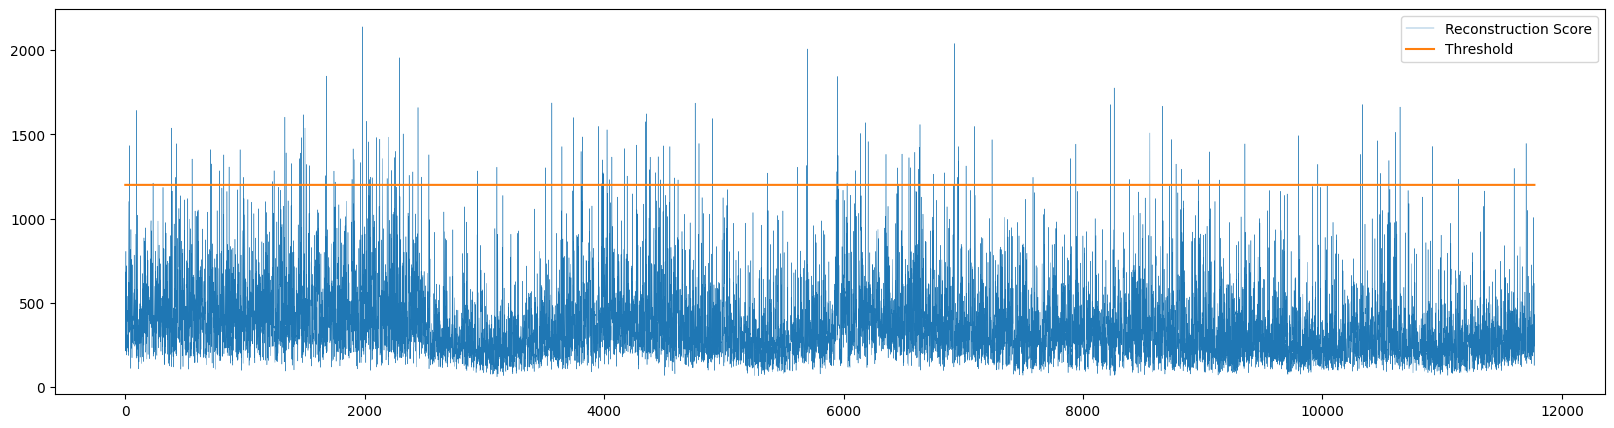

In [37]:
scores_fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([score[1] for score in mse_scores], label='Reconstruction Score', linewidth=0.3)
ax.plot(opts_eval.mse_score_thresh*np.ones(len(mse_scores)), label='Threshold')
plt.legend()
_ = plot_to_tensorboard(logger, scores_fig, 0, "test/mse")

Found 153 anomalies


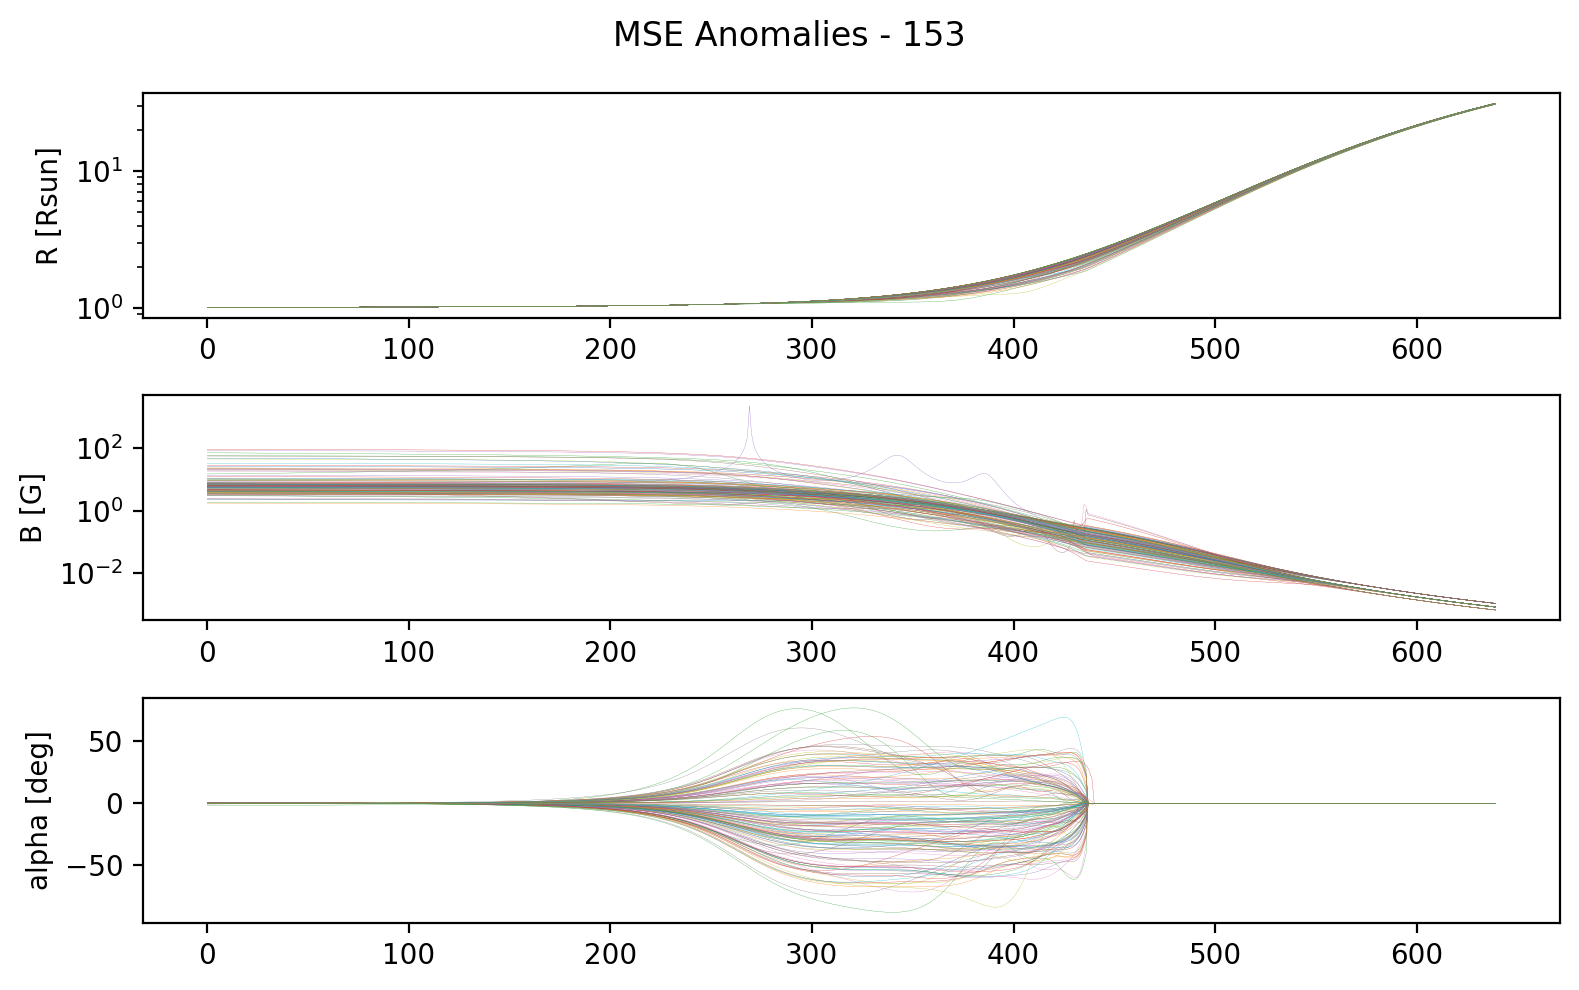

In [39]:
anomalies = [score[0] for score in mse_scores if score[1] > opts_eval.mse_score_thresh]
print(f"Found {len(anomalies)} anomalies")
anomal_fig = plot_anomalies(anomalies, opts.data_path, f"MSE Anomalies - {len(anomalies)}", figsize=(8, 5), dpi=200)
_ = plot_to_tensorboard(logger, anomal_fig, 0, "test/mse_anomalies")

### Feature Inverse Mapping

In [24]:
feature_scores = []
for i, (x, filenames) in enumerate(eval_dataloader):
    z = torch.zeros(x.shape, device=device, requires_grad=True)
    z_optimizer = torch.optim.Adam([z],lr=opts_eval.lr)
    
    loss = None
    for i in range(opts_eval.niter):
        G_z,_ = netG(z.cuda())
        loss = feature_anomaly_score(x.cuda(), G_z)
        loss.backward(gradient=loss)
        z_optimizer.step()

    feature_scores.extend(zip(filenames, [l.sum().detach().cpu().item() for l in loss]))
    # print(r_scores[-1])
    # loss_list.append(loss) # Store the loss from the final iteration
    print("[%d/%d]" % (i, len(eval_dataloader)), end='\r', flush=True)

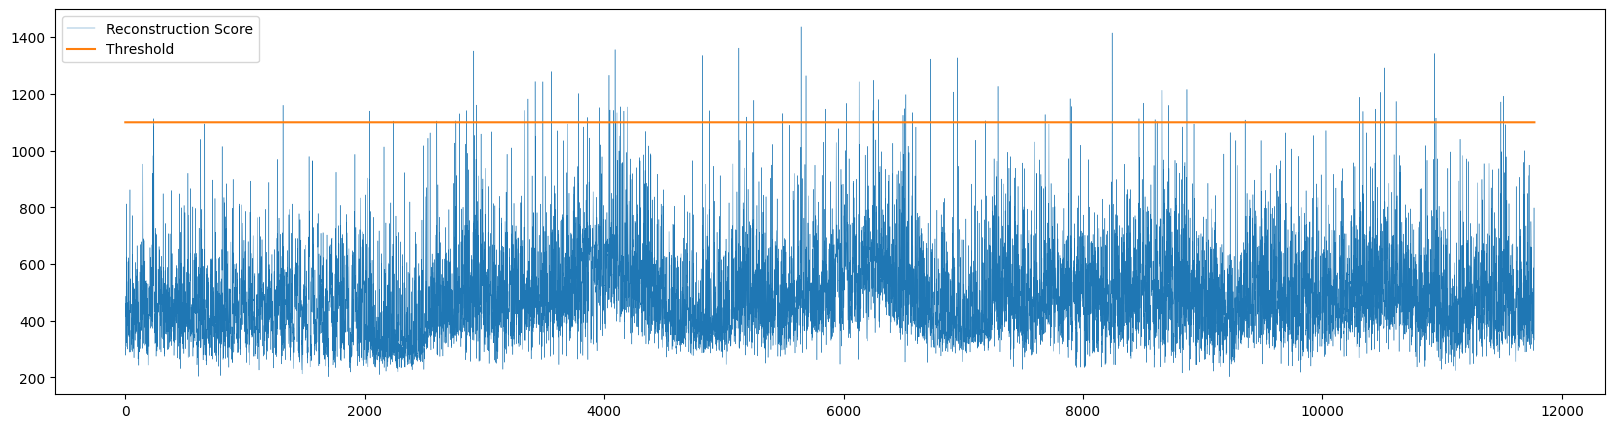

In [40]:
scores_fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([score[1] for score in feature_scores], label='Reconstruction Score', linewidth=0.3)
ax.plot(opts_eval.feature_score_thresh*np.ones(len(feature_scores)), label='Threshold')
plt.legend()
_ = plot_to_tensorboard(logger, scores_fig, 0, "test/feature")

Found 71 anomalies


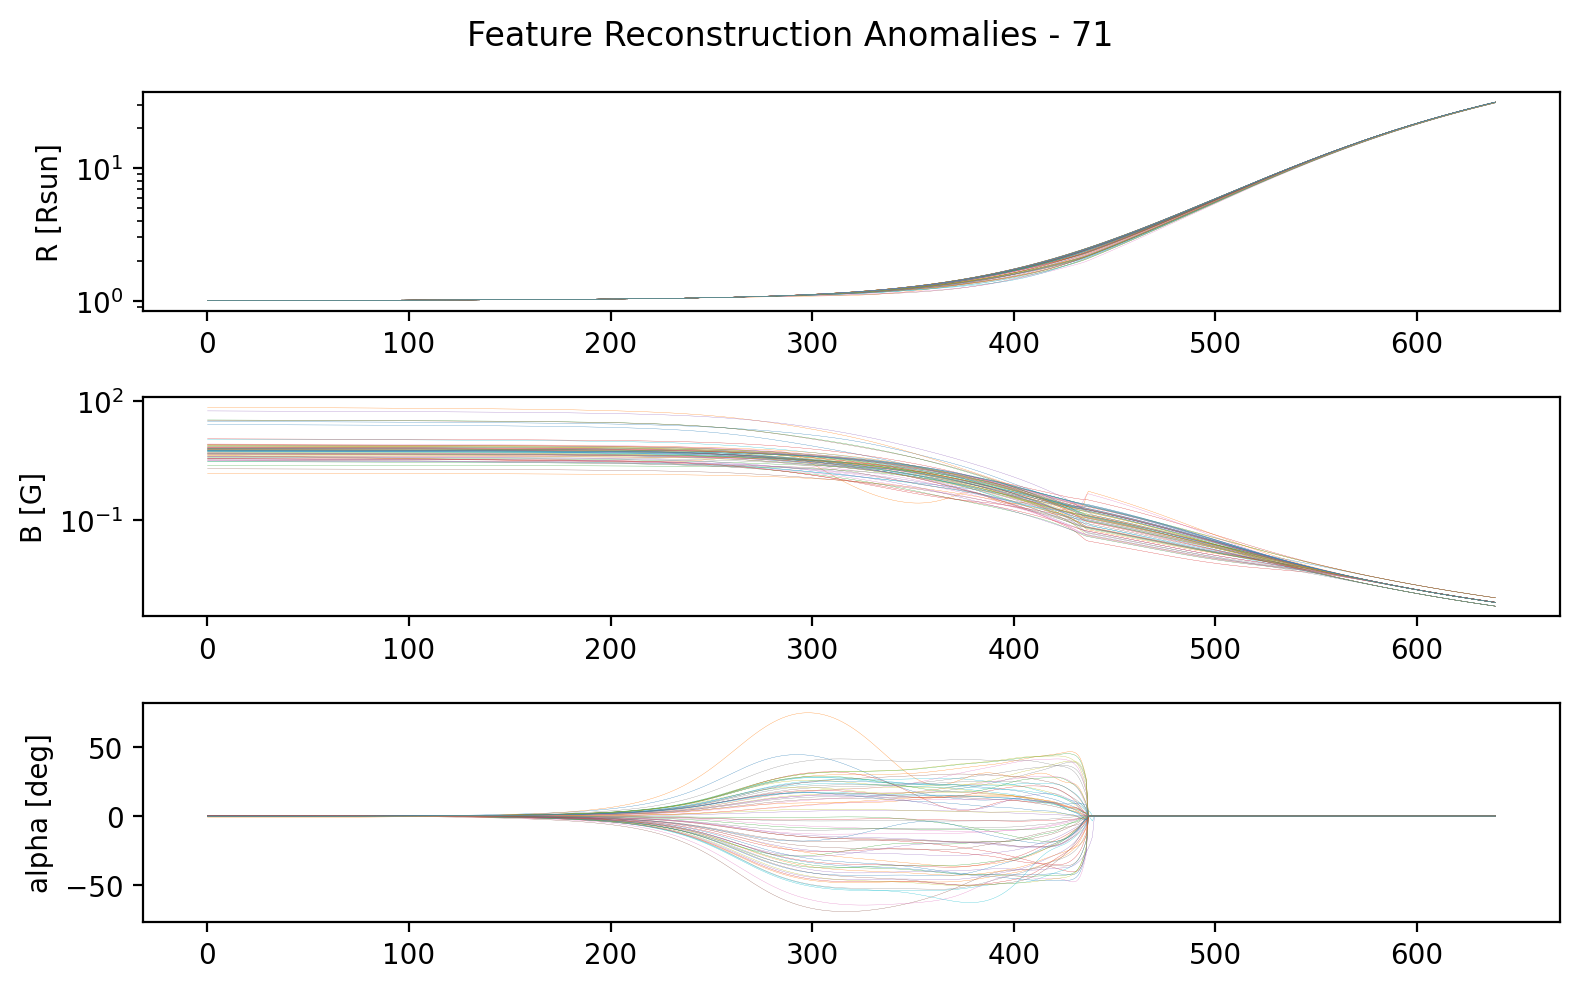

In [41]:
anomalies = [score[0] for score in feature_scores if score[1] > opts_eval.feature_score_thresh]

print(f"Found {len(anomalies)} anomalies")
anomal_fig = plot_anomalies(anomalies, opts.data_path, f"Feature Reconstruction Anomalies - {len(anomalies)}", figsize=(8, 5), dpi=200)
_ = plot_to_tensorboard(logger, anomal_fig, 0, "test/feature_anomalies")

In [42]:
logger.flush()